<a href="https://colab.research.google.com/github/jimmyland22/CMPE260/blob/main/CMPE260_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMPE-260 Term Project: Stock Market Predictor Using Temporal Difference

## Team
* Jimmy Liang
* Rohan Kumar
* Samer Baslan

## Summary 
The stock market prediction problem is considered to be a Markov process which can be optimized by using reinforcement learning based algorithms. Temporal difference, a reinforcement learning algorithm which leams only from experiences, will be adopted and function approximation by artificial neural network will be performed to leam the values of states each of which corresponds to a stock price trend at a given time.

## Prerequisite
* Hardware accelerator: GPU (preferred)

## References
* https://www.baeldung.com/cs/epsilon-greedy-q-learning
* https://exchange.ml4trading.io/

## Setup Notebook

In [1]:
!curl -L https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2 | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
!curl -L https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2 | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3765    0  3765    0     0   8817      0 --:--:-- --:--:-- --:--:--  8817
100  503k  100  503k    0     0   405k      0  0:00:01  0:00:01 --:--:--  916k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3853    0  3853    0     0   9754      0 --:--:-- --:--:-- --:--:--  9729
100  406k  100  406k    0     0   332k      0  0:00:01  0:00:01 --:--:--  332k


In [2]:
import os
import random
import sys
import warnings
from collections import deque
from pathlib import Path
from random import sample
from time import time

import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import talib
import tensorflow as tf
from gym import spaces
from gym.envs.registration import register
from gym.utils import seeding
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import scale
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [3]:
sys.modules[__name__]
warnings.filterwarnings("ignore")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

%matplotlib inline
sns.set_style("whitegrid")
pd.set_option("display.expand_frame_repr", False)

gpu_devices = tf.config.experimental.list_physical_devices("GPU")
if gpu_devices:
    print("GPU found!")
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)

GPU found!


## Configure Parameters

In [4]:
trading_days = 63 # Quarter
trading_cost_bps = 1e-3
time_cost_bps = 1e-4
ticker = "AMZN"

gamma = 0.99,
tau = 100
architecture = (256, 256)
learning_rate = 0.0001
l2_reg = 1e-6
replay_capacity = int(1e6)
batch_size = 4096
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay_steps = 250
epsilon_exponential_decay = 0.99

total_steps = 0
max_episodes = 1000

## Load Data

In [5]:
!rm -rf *

!mkdir data
!mkdir temp

!git clone https://github.com/jimmyland22/CMPE260.git

for i in range(6):
    zip_file = "/content/CMPE260/data/part_{}.zip".format(i + 1)
    !unzip $zip_file -d temp

print("Merging *.csv files...", end="")
!cat temp/*csv > data/wiki_prices.csv
print("done!")

!rm -rf CMPE260/
!rm -rf temp/

Cloning into 'CMPE260'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 45 (delta 13), reused 24 (delta 0), pack-reused 0
Unpacking objects: 100% (45/45), done.
Checking out files: 100% (11/11), done.
Archive:  /content/CMPE260/data/part_1.zip
  inflating: temp/xaa.csv            
Archive:  /content/CMPE260/data/part_2.zip
  inflating: temp/xab.csv            
Archive:  /content/CMPE260/data/part_3.zip
  inflating: temp/xac.csv            
Archive:  /content/CMPE260/data/part_4.zip
  inflating: temp/xad.csv            
Archive:  /content/CMPE260/data/part_5.zip
  inflating: temp/xae.csv            
Archive:  /content/CMPE260/data/part_6.zip
  inflating: temp/xaf.csv            
Merging *.csv files...done!


In [6]:
df = pd.read_csv("data/wiki_prices.csv",
              parse_dates=["date"],
              index_col=["date", "ticker"],
              infer_datetime_format=True).sort_index()

with pd.HDFStore("data/assets.h5") as store:
    store.put("quandl/wiki/prices", df)

df

open    high     low   close      volume  ex-dividend  split_ratio   adj_open   adj_high    adj_low  adj_close    adj_volume
date       ticker                                                                                                                                
1962-01-02 ARNC     65.56   65.75   65.38   65.38      5600.0          0.0          1.0   3.458163   3.468185   3.448668   3.448668  4.480000e+04
           BA       50.88   50.88   50.00   50.00     11595.0          0.0          1.0   0.887160   0.887160   0.871816   0.871816  3.521981e+05
           CAT      38.50   38.87   38.12   38.50     13600.0          0.0          1.0   1.578370   1.593539   1.562791   1.578370  1.632000e+05
           DD      241.50  244.25  241.50  241.50      2000.0          0.0          1.0   4.718414   4.772144   4.718414   4.718414  3.600000e+04
           DIS      37.25   38.50   37.25   37.25      2098.0          0.0          1.0   0.141259   0.145999   0.141259   0.141259  4.088582e+05
...                   ...     ...     ...     ...         ...          ...          ...        ...        ...        ...        ...           ...
2018-03-27 ZIXI      4.43    4.45    4.35    4.39    207304.0          0.0          1.0   4.430000   4.450000   4.350000   4.390000  2.073040e+05
           ZNGA      3.85    3.85    3.68    3.70  11026010.0          0.0          1.0   3.850000   3.850000   3.680000   3.700000  1.102601e+07
           ZOES     15.13   15.24   14.75   14.88    261242.0          0.0          1.0  15.130000  15.240000  14.750000  14.880000  2.612420e+05
           ZTS      84.08   84.45   81.21   81.86   2676191.0          0.0          1.0  84.080000  84.450000  81.210000  81.860000  2.676191e+06
           ZUMZ     24.65   24.65   23.35   23.60    403884.0          0.0          1.0  24.650000  24.650000  23.350000  23.600000  4.038840e+05

[15389314 rows x 12 columns]

## Implement Gym Environment

In [7]:
class DataSource:
    def __init__(self, trading_days=252, ticker="AAPL", normalize=True):
        self.trading_days = trading_days
        self.ticker = ticker
        self.normalize = normalize
        self.data = self.load_data()
        self.preprocess_data()
        self.min_values = self.data.min()
        self.max_values = self.data.max()
        self.step = 0
        self.offset = None

    def load_data(self):
        print("Loading data for {}...".format(self.ticker), end="")
        idx = pd.IndexSlice
        with pd.HDFStore("data/assets.h5") as store:
            df = (store["quandl/wiki/prices"]
                  .loc[idx[:, self.ticker], ["adj_close", "adj_volume", "adj_low", "adj_high"]]
                  .dropna()
                  .sort_index())
        df.columns = ["close", "volume", "low", "high"]
        print("done!")
        return df

    def preprocess_data(self):
        self.data["returns"] = self.data.close.pct_change()
        self.data["ret_2"] = self.data.close.pct_change(2)
        self.data["ret_5"] = self.data.close.pct_change(5)
        self.data["ret_10"] = self.data.close.pct_change(10)
        self.data["ret_21"] = self.data.close.pct_change(21)
        self.data["rsi"] = talib.STOCHRSI(self.data.close)[1]
        self.data["macd"] = talib.MACD(self.data.close)[1]
        self.data["atr"] = talib.ATR(self.data.high, self.data.low, self.data.close)
        slowk, slowd = talib.STOCH(self.data.high, self.data.low, self.data.close)
        self.data["stoch"] = slowd - slowk
        self.data["atr"] = talib.ATR(self.data.high, self.data.low, self.data.close)
        self.data["ultosc"] = talib.ULTOSC(self.data.high, self.data.low, self.data.close)
        self.data = (self.data
                     .replace((np.inf, -np.inf), np.nan)
                     .drop(["high", "low", "close", "volume"], axis=1)
                     .dropna())
        r = self.data.returns.copy()
        if self.normalize:
            self.data = pd.DataFrame(scale(self.data), columns=self.data.columns, index=self.data.index)
        features = self.data.columns.drop("returns")
        self.data["returns"] = r
        self.data = self.data.loc[:, ["returns"] + list(features)]

    def reset(self):
        high = len(self.data.index) - self.trading_days
        self.offset = np.random.randint(low=0, high=high)
        self.step = 0

    def take_step(self):
        obs = self.data.iloc[self.offset + self.step].values
        self.step += 1
        done = self.step > self.trading_days
        return obs, done

In [8]:
class TradingSimulator:
    def __init__(self, steps, trading_cost_bps, time_cost_bps):
        self.steps = steps
        self.trading_cost_bps = trading_cost_bps
        self.time_cost_bps = time_cost_bps
        self.step = 0
        self.actions = np.zeros(self.steps)
        self.navs = np.ones(self.steps)
        self.market_navs = np.ones(self.steps)
        self.strategy_returns = np.ones(self.steps)
        self.positions = np.zeros(self.steps)
        self.costs = np.zeros(self.steps)
        self.trades = np.zeros(self.steps)
        self.market_returns = np.zeros(self.steps)

    def reset(self):
        self.step = 0
        self.actions.fill(0)
        self.navs.fill(1)
        self.market_navs.fill(1)
        self.strategy_returns.fill(0)
        self.positions.fill(0)
        self.costs.fill(0)
        self.trades.fill(0)
        self.market_returns.fill(0)

    def take_step(self, action, market_return):
        start_position = self.positions[max(0, self.step - 1)]
        start_nav = self.navs[max(0, self.step - 1)]
        start_market_nav = self.market_navs[max(0, self.step - 1)]
        self.market_returns[self.step] = market_return
        self.actions[self.step] = action
        end_position = action - 1
        n_trades = end_position - start_position
        self.positions[self.step] = end_position
        self.trades[self.step] = n_trades
        trade_costs = abs(n_trades) * self.trading_cost_bps
        time_cost = 0 if n_trades else self.time_cost_bps
        self.costs[self.step] = trade_costs + time_cost
        reward = start_position * market_return - self.costs[self.step]
        self.strategy_returns[self.step] = reward
        if self.step != 0:
            self.navs[self.step] = start_nav * (1 + self.strategy_returns[self.step])
            self.market_navs[self.step] = start_market_nav * (1 + self.market_returns[self.step])
        info = {"reward": reward,
                "nav": self.navs[self.step],
                "costs": self.costs[self.step]}
        self.step += 1
        return reward, info

    def result(self):
        return pd.DataFrame({"action": self.actions,
                             "nav": self.navs,
                             "market_nav": self.market_navs,
                             "market_return": self.market_returns,
                             "strategy_return": self.strategy_returns,
                             "position": self.positions,
                             "cost": self.costs,
                             "trade": self.trades})

In [9]:
class TradingEnvironment(gym.Env):
    metadata = {"render.modes": ["human"]}

    def __init__(self, trading_days=252, trading_cost_bps=1e-3, time_cost_bps=1e-4, ticker="AAPL"):
        self.trading_days = trading_days
        self.trading_cost_bps = trading_cost_bps
        self.time_cost_bps = time_cost_bps
        self.ticker = ticker
        self.data_source = DataSource(self.trading_days, ticker)
        self.simulator = TradingSimulator(self.trading_days, self.trading_cost_bps, self.time_cost_bps)
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(self.data_source.min_values, self.data_source.max_values)
        self.reset()
        self.np_random = None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action), "{} {} invalid".format(action, type(action))
        observation, done = self.data_source.take_step()
        reward, info = self.simulator.take_step(action, observation[0])
        return observation, reward, done, info

    def reset(self):
        self.data_source.reset()
        self.simulator.reset()
        return self.data_source.take_step()[0]

    def render(self, mode="human"):
        pass

In [10]:
id = "trading-v0"
entry_point = "__main__:TradingEnvironment"

for env in gym.envs.registry.env_specs.copy():
     if id in env:
          del gym.envs.registration.registry.env_specs[env]

register(id=id, entry_point=entry_point, max_episode_steps=trading_days)

## Implement Agent

In [11]:
class DDQNAgent:
    def __init__(self, state_dim, num_actions, learning_rate, gamma,
                 epsilon_start, epsilon_end, epsilon_decay_steps, epsilon_exponential_decay,
                 replay_capacity, architecture, l2_reg, tau, batch_size, train=True):

        self.state_dim = state_dim
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_decay = (epsilon_start - epsilon_end) / epsilon_decay_steps
        self.epsilon_decay_steps = epsilon_decay_steps
        self.epsilon_exponential_decay = epsilon_exponential_decay
        self.experience = deque([], maxlen=replay_capacity)
        self.architecture = architecture
        self.l2_reg = l2_reg
        self.tau = tau
        self.batch_size = batch_size
        self.train = train

        self.online_network = self.build_model()
        self.target_network = self.build_model(trainable=False)
        self.update_target()

        self.total_steps = self.train_steps = 0
        self.episode_reward = 0
        self.episodes = self.episode_length = self.train_episodes = 0
        self.rewards_history = []
        self.steps_per_episode = []
        self.idx = tf.range(batch_size)
        self.losses = []

    def build_model(self, trainable=True):
        layers = []
        for i, units in enumerate(self.architecture, 1):
            layers.append(Dense(units=units,
                                input_dim=self.state_dim if i == 1 else None,
                                activation="relu",
                                kernel_regularizer=l2(self.l2_reg),
                                name=f"Dense_{i}",
                                trainable=trainable))
        layers.append(Dropout(0.1))
        layers.append(Dense(units=self.num_actions,
                            trainable=trainable,
                            name="Output"))
        model = Sequential(layers)
        model.compile(loss="mean_squared_error", optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target(self):
        self.target_network.set_weights(self.online_network.get_weights())

    def epsilon_greedy_policy(self, state):
        self.total_steps += 1
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.num_actions)
        q = self.online_network.predict(state)
        return np.argmax(q, axis=1).squeeze()

    def memorize_transition(self, s, a, r, s_prime, not_done):
        if not_done:
            self.episode_reward += r
            self.episode_length += 1
        else:
            if self.train:
                if self.episodes < self.epsilon_decay_steps:
                    self.epsilon -= self.epsilon_decay
                else:
                    self.epsilon *= self.epsilon_exponential_decay
            self.episodes += 1
            self.rewards_history.append(self.episode_reward)
            self.steps_per_episode.append(self.episode_length)
            self.episode_reward, self.episode_length = 0, 0
        self.experience.append((s, a, r, s_prime, not_done))

    def experience_replay(self):
        if self.batch_size > len(self.experience):
            return
        states, actions, rewards, next_states, not_done = map(np.array, zip(*sample(self.experience, self.batch_size)))
        next_q_values = self.online_network.predict_on_batch(next_states)
        best_actions = tf.argmax(next_q_values, axis=1)
        next_q_values_target = self.target_network.predict_on_batch(next_states)
        target_q_values = tf.gather_nd(next_q_values_target, tf.stack((self.idx, tf.cast(best_actions, tf.int32)), axis=1))
        targets = rewards + not_done * self.gamma * target_q_values
        q_values = self.online_network.predict_on_batch(states)
        q_values[[self.idx, actions]] = targets
        loss = self.online_network.train_on_batch(x=states, y=q_values)
        self.losses.append(loss)
        if self.total_steps % self.tau == 0:
            self.update_target()

## Implement Agent Train Loop

In [12]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return "{:02.0f}:{:02.0f}:{:02.0f}".format(h, m, s)

def track_results(episode, nav_ma_100, nav_ma_10, market_nav_100, market_nav_10, win_ratio, total, epsilon):
    template = "{:>4d} | {} | Agent: {:>6.1%} ({:>6.1%}) | Market: {:>6.1%} ({:>6.1%}) | Wins: {:>5.1%} | eps: {:>6.3f}"
    print(template.format(episode, format_time(total), nav_ma_100 - 1, nav_ma_10 - 1, market_nav_100 - 1, market_nav_10 - 1, win_ratio, epsilon))

def train_agent(env, with_policy):
    env.seed(SEED)
    state_dim = env.observation_space.shape[0]
    num_actions = env.action_space.n
    tf.keras.backend.clear_session()

    ddqn = DDQNAgent(state_dim, num_actions, learning_rate, gamma,
                     epsilon_start, epsilon_end, epsilon_decay_steps, epsilon_exponential_decay,
                     replay_capacity, architecture, l2_reg, tau, batch_size, with_policy)

    results, navs, market_navs, diffs = [], [], [], []
    episodes = range(1, max_episodes + 1)
    start = time()

    for episode in episodes:
        this_state = env.reset()
        for episode_step in range(env.spec.max_episode_steps):
            action = ddqn.epsilon_greedy_policy(this_state.reshape(-1, state_dim))
            next_state, reward, done, _ = env.step(action)
            ddqn.memorize_transition(this_state, action, reward, next_state, 0.0 if done else 1.0)
            if ddqn.train:
                ddqn.experience_replay()
            if done:
                break
            this_state = next_state

        result = env.env.simulator.result()
        final = result.iloc[-1]
        nav = final.nav * (1 + final.strategy_return)
        navs.append(nav)
        market_nav = final.market_nav
        market_navs.append(market_nav)
        diff = nav - market_nav
        diffs.append(diff)

        track_results(episode,
                      np.mean(navs[-100:]),
                      np.mean(navs[-10:]),
                      np.mean(market_navs[-100:]),
                      np.mean(market_navs[-10:]),
                      np.sum([s > 0 for s in diffs[-100:]]) / min(len(diffs), 100),
                      time() - start,
                      ddqn.epsilon)

        if len(diffs) > 25 and all([r > 0 for r in diffs[-25:]]):
            print(result.tail())
            break

    env.close()

    results = pd.DataFrame({"Episode": list(episodes),
                            "Agent": navs,
                            "Market": market_navs,
                            "Difference": diffs}).set_index("Episode")
    results["Strategy Wins (%)"] = (results.Difference > 0).rolling(100).sum()

    with sns.axes_style("white"):
        sns.distplot(results.Difference)
        sns.despine()

    fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)
    df1 = results[["Agent", "Market"]].sub(1).rolling(100).mean()
    df1.plot(ax=axes[0], title="{}: Annual Returns (Moving Average)".format(ticker), lw=1)
    df2 = results["Strategy Wins (%)"].div(100).rolling(50).mean()
    df2.plot(ax=axes[1], title="{}: Agent Outperformance (%, Moving Average)".format(ticker))
    for ax in axes:
        ax.yaxis.set_major_formatter(
            FuncFormatter(lambda y, _: "{:.0%}".format(y)))
        ax.xaxis.set_major_formatter(
            FuncFormatter(lambda x, _: "{:,.0f}".format(x)))
    axes[1].axhline(.5, ls="--", c="k", lw=1)
    fig.tight_layout()

    return results

## Train Agent Without Any Policy

In [13]:
env = gym.make("trading-v0",
               trading_days=trading_days,
               trading_cost_bps=trading_cost_bps,
               time_cost_bps=time_cost_bps,
               ticker=ticker)

Loading data for AMZN...done!


   1 | 00:00:00 | Agent:  -2.0% ( -2.0%) | Market:  12.4% ( 12.4%) | Wins:  0.0% | eps:  1.000
   2 | 00:00:00 | Agent: -13.0% (-13.0%) | Market:  -0.4% ( -0.4%) | Wins:  0.0% | eps:  1.000
   3 | 00:00:00 | Agent:  -1.4% ( -1.4%) | Market:  -6.2% ( -6.2%) | Wins: 33.3% | eps:  1.000
   4 | 00:00:00 | Agent:  -3.1% ( -3.1%) | Market:   2.4% (  2.4%) | Wins: 25.0% | eps:  1.000
   5 | 00:00:00 | Agent:  -1.1% ( -1.1%) | Market:   5.5% (  5.5%) | Wins: 20.0% | eps:  1.000
   6 | 00:00:00 | Agent:  -3.2% ( -3.2%) | Market:   7.1% (  7.1%) | Wins: 16.7% | eps:  1.000
   7 | 00:00:00 | Agent:  -5.5% ( -5.5%) | Market:   5.0% (  5.0%) | Wins: 14.3% | eps:  1.000
   8 | 00:00:00 | Agent: -11.6% (-11.6%) | Market:   6.0% (  6.0%) | Wins: 12.5% | eps:  1.000
   9 | 00:00:00 | Agent: -12.0% (-12.0%) | Market:   6.9% (  6.9%) | Wins: 11.1% | eps:  1.000
  10 | 00:00:00 | Agent: -11.7% (-11.7%) | Market:   5.8% (  5.8%) | Wins: 10.0% | eps:  1.000
  11 | 00:00:00 | Agent: -12.8% (-13.9%) | Market:

,Agent,Market,Difference,Strategy Wins (%)
Episode,,,,
1,0.980412,1.123670,-0.143257,NaN
2,0.759322,0.868852,-0.109530,NaN
3,1.217815,0.820543,0.397272,NaN
4,0.919685,1.282873,-0.363188,NaN
5,1.068707,1.178133,-0.109426,NaN
...,...,...,...,...
996,0.860916,1.095144,-0.234228,27.0
997,1.032393,1.056737,-0.024344,26.0
998,0.938705,1.097939,-0.159234,26.0


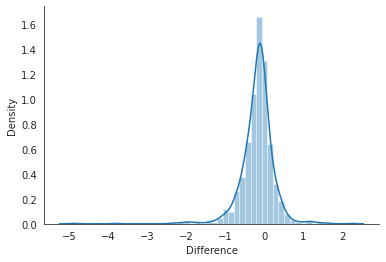

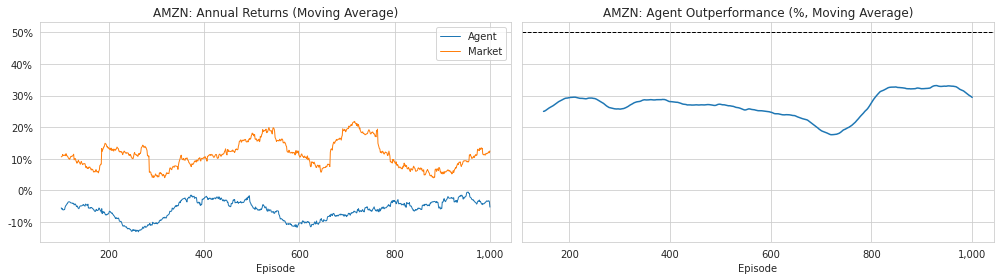

In [14]:
train_agent(env, with_policy=False)

## Train Agent With Epsilon-Greedy Policy

   1 | 00:00:00 | Agent:  40.9% ( 40.9%) | Market:   6.6% (  6.6%) | Wins: 100.0% | eps:  0.996
   2 | 00:00:00 | Agent:  20.2% ( 20.2%) | Market:  19.3% ( 19.3%) | Wins: 50.0% | eps:  0.992
   3 | 00:00:00 | Agent:  18.7% ( 18.7%) | Market:  30.8% ( 30.8%) | Wins: 33.3% | eps:  0.988
   4 | 00:00:03 | Agent:  10.3% ( 10.3%) | Market:  19.5% ( 19.5%) | Wins: 25.0% | eps:  0.984
   5 | 00:00:03 | Agent:   5.6% (  5.6%) | Market:  14.8% ( 14.8%) | Wins: 20.0% | eps:  0.980
   6 | 00:00:03 | Agent:   6.0% (  6.0%) | Market:  11.9% ( 11.9%) | Wins: 33.3% | eps:  0.976
   7 | 00:00:03 | Agent:   1.8% (  1.8%) | Market:   9.9% (  9.9%) | Wins: 28.6% | eps:  0.972
   8 | 00:00:03 | Agent:   1.0% (  1.0%) | Market:  10.1% ( 10.1%) | Wins: 25.0% | eps:  0.968
   9 | 00:00:03 | Agent:  -1.1% ( -1.1%) | Market:  11.0% ( 11.0%) | Wins: 22.2% | eps:  0.964
  10 | 00:00:03 | Agent:  -3.4% ( -3.4%) | Market:  11.7% ( 11.7%) | Wins: 20.0% | eps:  0.960
  11 | 00:00:03 | Agent:  -5.3% (-10.0%) | Market

,Agent,Market,Difference,Strategy Wins (%)
Episode,,,,
1,1.408899,1.066473,0.342426,NaN
2,0.994633,1.318614,-0.323982,NaN
3,1.158128,1.538416,-0.380288,NaN
4,0.851454,0.857387,-0.005934,NaN
5,0.865563,0.958493,-0.092930,NaN
...,...,...,...,...
996,1.172243,1.125281,0.046962,44.0
997,0.993313,0.921452,0.071861,45.0
998,0.878154,1.417953,-0.539799,44.0


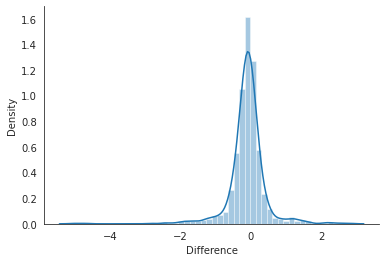

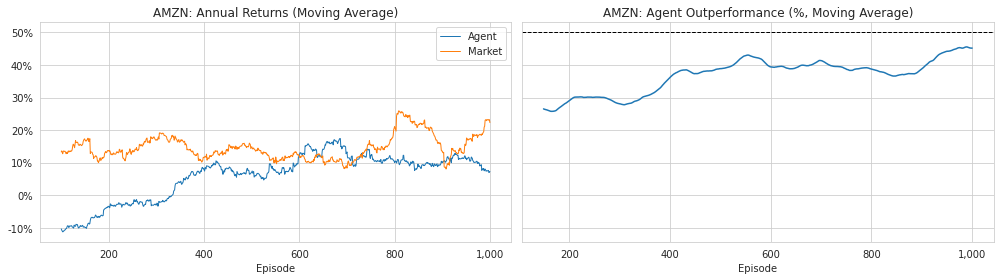

In [15]:
train_agent(env, with_policy=True)